In [20]:
import numpy as np
import scipy
import time
import matplotlib.pyplot as plt

In [7]:
def definir_matriz(shape, seed=None):
    return np.random.randn(shape[0], shape[1])*2 - 1

### **Ejercicio 1**: Implementar descompLU

In [4]:
def descompLU(A):
    # Como no hay pivoteo, si A[0][0] es 0, debe tirar error
    if A[0][0] == 0:
        raise AssertionError('Error: hay un 0')
    # Caso Base
    if A.shape == (1,1):
        return 1, A[0][0] 

    # Busco los datos para armar mis matrices L y U
    u11 = A[0][0]
    U12 = A[0][1:]
    L21 = A[1:,0] / u11
    L22U22 = A[1:,1:] - np.outer(L21, U12)

    # empiezo a armar mi L, U de cada vuelta de la recursión
    L22, U22 = descompLU(L22U22)

    U = np.zeros(A.shape)
    U[0][0] = u11
    U[0][1:] = U12
    U[1:, 1:] = U22

    L = np.eye(A.shape[0])
    L[1:,0] = L21
    L[1:, 1:] = L22

    return L, U

<h4>Ejemplo de uso:</h4>
Queremos comprobar el siguiente resultado, que fue resuelto con calculadora:
$$
A = LU
\iff
\begin{pmatrix}
        1 & 2 & 3 \\
        4 & 5 & 6 \\
        7 & 8 & 9
    \end{pmatrix}
=
\begin{pmatrix}
        1 & 0 & 0 \\
        5 & 1 & 0 \\
        7 & 1.2 & 1
    \end{pmatrix}
\cdot
\begin{pmatrix}
        1 & 2 & 3 \\
        0 & -5 & -9 \\
        0 & 0 & -1.2
    \end{pmatrix}
$$

In [5]:
A = np.array([[1,2,3], [5,5,6], [7,8,9]])
L, U = descompLU(A)

print(L,"\n")
print(U)

[[1.  0.  0. ]
 [5.  1.  0. ]
 [7.  1.2 1. ]] 

[[ 1.   2.   3. ]
 [ 0.  -5.  -9. ]
 [ 0.   0.  -1.2]]


---

### **Ejercicio 3**: Implementar resolverLU
Resolvemos un sistema de ecuaciones utilizando la descomp. $LU$ y resolviendo los sistemas $Ly = b$ y $Ux = y$ con la libreria `scipy`

In [6]:
def resolverLU(A, b):
    L, U = descompLU(A)
    y = scipy.linalg.solve_triangular(L,b, lower = True)
    res = scipy.linalg.solve_triangular(U, y)
    return res

---

### **Ejercicio 4**: Calcular error relativo
Primero, defino una función para calcular el error relativo entre dos componentes, ya que lo vamos a usar más adelante. Luego, calculo el error descripto en el ejercicio.

In [11]:
def error_rel_n2(x, y):
    res = np.linalg.norm(x-y,ord=2)/np.linalg.norm(y,ord=2)
    return res

In [14]:
A = definir_matriz((10,10))
b = definir_matriz((1,10))[0]
x = resolverLU(A, b)

error = np.log(error_rel_n2(A@x, b))

print("El error relativo entre {} y {} es: {}".format(A@x, b, error))

El error relativo entre [-1.14578814  2.00028329 -3.68204026 -1.83063164  0.83099137 -0.30612347
  0.93239435 -0.70077526 -1.44032748 -2.48291494] y [-1.14578814  2.00028329 -3.68204026 -1.83063164  0.83099137 -0.30612347
  0.93239435 -0.70077526 -1.44032748 -2.48291494] es: -28.826993091586903


---

### **Ejercicio 5**: Implementar inversa
Calculamos la inversa armandonos una matriz identidad y resolviendo el sistema, así encontramos la solución del problema de manera matricial, sin tener que encontrar cada uno de los vectores $e_i$ individualmente.

Si no tiene inversa, tira un error.

In [17]:
def inversa(A):
    try:
        L, U = descompLU(A)
        In = np.eye(A.shape[0]) # matriz identidad
        y = scipy.linalg.solve_triangular(L, In, lower = True)
        res = scipy.linalg.solve_triangular(U, y)
        return res
    except scipy.linalg.LinAlgError:
        print('Error! Matriz Singular :,( ')

A = np.array([[1,2,3],[5,5,6],[7,8,9]])
inversa(A)

array([[-0.5       ,  1.        , -0.5       ],
       [-0.5       , -2.        ,  1.5       ],
       [ 0.83333333,  1.        , -0.83333333]])

---

### **Ejercicio 6**: Calcular error de inversa
Utilizamos la norma Frobenius para calcular el error de nuestra inversa haciendo $\|A^{-1}A - I\|_F$ ya que, por definición, $A^{-1}A = I$

In [18]:
A = definir_matriz((10,10))
Ainv = inversa(A)
np.linalg.norm(Ainv@A - np.eye(A.shape[0]), ord='fro') # Norma Frobenius

2.103759803782083e-14

---

### **Ejercicio 7**: Diferencias entre Métodos para resolver sistemas lineales
En este ejercicio vamos a entender que método tiene menos error al resolver sistemas, si calcular la inversa o solo resolviendo LU, utilizando el error relativo.

También nos pareció interesante analizar el tiempo de ejecución de cada método.

In [23]:
v1 = np.zeros(200)
tiempo1 = np.zeros(200)

# Buscamos errores para ResolverLU
for n in range(10, 201):
    suma_errores = 0
    start = time.time()
    for i in range(10):
        # Definimos la matriz A, x y b tal que Ax = b
        A = definir_matriz((n,n))
        x = np.random.randn(n)*2-1
        b = A@x

        # Resolvemos el sistema Ax = b y calculamos el error
        x1 = resolverLU(A,b)
        suma_errores += np.log(error_rel_n2(A@x1,b))

    tiempo1[n-1] = time.time() - start
    v1[n-1] = suma_errores

In [24]:
v2 = np.zeros(200)
tiempo2 = np.zeros(200)

# Buscamos errores para Inversa
for n in range(10, 201):
    suma_errores = 0
    start = time.time()
    for i in range(10):
        # Definimos la matriz A, x y b tal que Ax = b
        A = definir_matriz((n,n))
        x = np.random.randn(n)*2-1
        b = A@x

        # Resolvemos el sistema Ax = b y calculamos el error
        x2 = inversa(A)@b
        suma_errores += np.log(error_rel_n2(A@x2,b))

    v2[n-1] = suma_errores
    tiempo2[n-1] = time.time() - start

Ahora graficamos el error relativo de cada uno

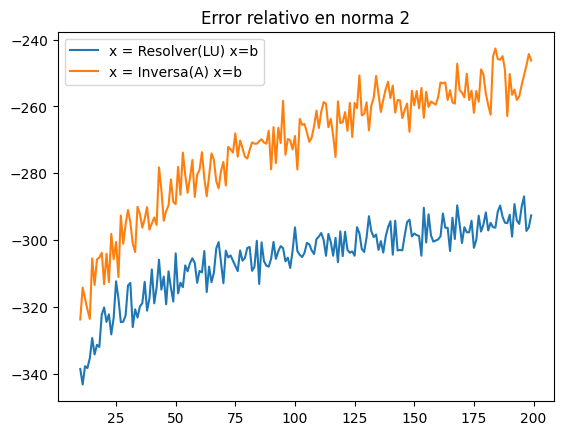

In [25]:
n = np.arange(10, len(v1))
plt.plot(n, v1[10:], label='x = Resolver(LU) x=b')
plt.plot(n, v2[10:], label='x = Inversa(A) x=b')
plt.title('Error relativo en norma 2')

plt.legend()
plt.show()

Podemos ver que "ResolverLU" tiene menos error relativo que "Inversa". Creemos que tiene que ver con que la función Inversa hace más pasos que ResolverLU, entonces los errores se arrastran más.

Ahora vemos el tiempo de ejecución:

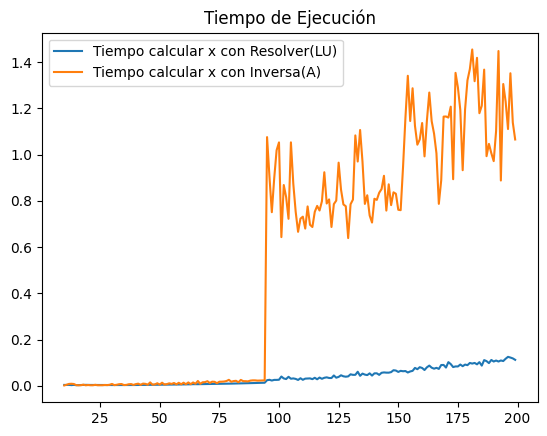

In [26]:
import matplotlib.pyplot as plt
n = np.arange(10, len(v1))
plt.plot(n, tiempo1[10:], label='Tiempo calcular x con Resolver(LU)')
plt.plot(n, tiempo2[10:], label='Tiempo calcular x con Inversa(A)')
plt.title('Tiempo de Ejecución')

plt.legend()
plt.show()

**Nota**: En mi computadora a partir del 95 los tiempos son extremadamente inusuales, no se pueden sacar conclusiones.

---

### **Ejercicio 7**: Calcular el error de la solución
Se calcula el error de la solución ($x$) en vez de calcular el resultado ($b$). Se esperaría un comportamiento similar.

In [29]:
v1 = np.zeros(200)
tiempo1 = np.zeros(200)

# Buscamos errores para ResolverLU
for n in range(10, 201):
    suma_errores = 0
    start = time.time()
    for i in range(10):
        # Definimos la matriz A, x y b tal que Ax = b
        A = definir_matriz((n,n))
        x = np.random.randn(n)*2-1
        b = A@x

        # Resolvemos el sistema Ax = b y calculamos el error
        x1 = resolverLU(A,b)
        suma_errores += np.log(error_rel_n2(x1,x))

    tiempo1[n-1] = time.time() - start
    v1[n-1] = suma_errores